In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import torch
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

METADATA_DIR = 'data/metadata'
FACES_DIR = 'faces_saved'

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
%%time

VIDEO_NAMES = []
VIDEO_LABELS = []
for file in os.listdir(METADATA_DIR):
    df = pd.read_json(os.path.join(METADATA_DIR, file))
    video_names_file = list(df.index)
    video_labels_file = list(df['label'].values)
    VIDEO_NAMES = VIDEO_NAMES + video_names_file
    VIDEO_LABELS = VIDEO_LABELS + video_labels_file

len(VIDEO_NAMES), len(VIDEO_LABELS)

CPU times: user 1.37 s, sys: 52 ms, total: 1.42 s
Wall time: 4.58 s


(119154, 119154)

In [3]:
%%time

FACES_PATHS = []
FACES_LABELS = []

start_time = time.time()

def extract_path_label(i):
    faces = glob.glob(os.path.join(FACES_DIR, os.path.splitext(VIDEO_NAMES[i])[0]) + '/*.png')
    if VIDEO_LABELS[i] == 'REAL':
        label = 0
    else:
        label = 1
    for face in faces:
        FACES_PATHS.append(face)
        FACES_LABELS.append(label)
    if i % 240 == 0:
        print('{}/{} ({:.6f}%) passed ({} / {})'.format(
                    i,
                    len(VIDEO_NAMES),
                    i / len(VIDEO_NAMES) * 100,
                    timedelta(seconds=time.time() - start_time),
                    timedelta(seconds=time.time() - start_time) / i * len(VIDEO_NAMES)
                ))
    
with ThreadPoolExecutor(max_workers=4) as ex:
    ex.map(extract_path_label, range(len(VIDEO_NAMES)))

len(FACES_PATHS), len(FACES_LABELS)

KeyboardInterrupt: 

In [3]:
%%time

FACES_PATHS = []
FACES_LABELS = []
for i in tqdm(range(len(VIDEO_NAMES))):
    faces = glob.glob(os.path.join(FACES_DIR, os.path.splitext(VIDEO_NAMES[i])[0]) + '/*.png')
    if VIDEO_LABELS[i] == 'REAL':
        label = 0
    else:
        label = 1
    for face in faces:
        FACES_PATHS.append(face)
        FACES_LABELS.append(label)

len(FACES_PATHS), len(FACES_LABELS)

100%|██████████| 119154/119154 [29:36<00:00, 67.08it/s]  

CPU times: user 23.4 s, sys: 10.2 s, total: 33.6 s
Wall time: 29min 36s


(1085181, 1085181)

In [3]:
%%time

FACES_PATHS = []
# FACES_LABELS = []
for i in tqdm(range(len(VIDEO_NAMES))):
    faces = glob.glob(os.path.join(FACES_DIR, os.path.splitext(VIDEO_NAMES[i])[0]) + '/*.png')
#     if VIDEO_LABELS[i] == 'REAL':
#         label = 0
#     else:
#         label = 1
    for face in faces:
        FACES_PATHS.append(face)
#         FACES_LABELS.append(label)

len(FACES_PATHS), len(FACES_LABELS)

100%|██████████| 119154/119154 [34:53<00:00, 56.91it/s]


NameError: name 'FACES_LABELS' is not defined

In [4]:
%%time

import pickle

with open('FACES_PATHS.pickle', 'wb') as handle:
    pickle.dump(FACES_PATHS, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 228 ms, sys: 72 ms, total: 300 ms
Wall time: 419 ms


In [5]:
%%time

with open('FACES_LABELS.pickle', 'wb') as handle:
    pickle.dump(FACES_LABELS, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 24.3 ms


In [5]:
FACES_PATHS[0]

'faces_saved/aaragvjucp/face_232.png'

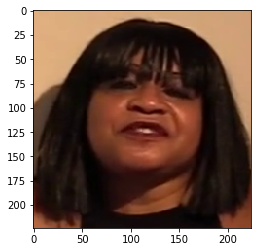

In [8]:
plt.imshow(cv2.cvtColor(cv2.imread(FACES_PATHS[0]), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, faces_paths, faces_labels, datatype='train', transform=None):
        self.faces_paths = faces_paths
        self.datatype = datatype
        assert self.datatype in ['train', 'val', 'test']
        self.labels = faces_labels
        self.transform = transform

    def __len__(self):
        return len(self.faces_paths)

    def __getitem__(self, idx):
        img_name = self.faces_paths[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (256, 256))
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
        if self.transform:
            img = self.transform(image=img)['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels[idx]
        if self.datatype == 'test':
            return img, label, img_name
        else:
            return img, label